In [1]:
from keras.datasets import cifar10
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.layers.merge import add

Using TensorFlow backend.


In [0]:
def dim_ordering():
  global row_axis
  global col_axis
  global channel_axis
  
  if K.image_dim_ordering() == 'tf':
    row_axis = 1
    col_axis = 2
    channel_axis = 3
  else:
    channel_axis = 1
    row_axis = 2
    col_axis = 3

def _bn_relu_conv(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_regularizer = l2(1e-4), kernel_initializer = "he_normal"):
    
  def f(input_x):
    x = keras.layers.BatchNormalization(axis = channel_axis)(input_x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding,
                              kernel_regularizer = kernel_regularizer, kernel_initializer = kernel_initializer)(x)
    return x  
    
  return f
  
def _conv_bn_relu(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_regularizer = l2(1e-4), kernel_initializer = "he_normal"):
    
  def f(input_x):
    x = keras.layers.Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding,
                              kernel_regularizer = kernel_regularizer, kernel_initializer = kernel_initializer)(input_x)
    x = keras.layers.BatchNormalization(axis = channel_axis)(x)
    x = keras.layers.Activation('relu')(x)
      
    return x
    
  return f 
  
  
def _shortcut(input_x, residual):
    
  input_shape = K.int_shape(input_x)
  res_shape = K.int_shape(residual)
  stride_width = int(round(input_shape[col_axis] / res_shape[col_axis]))
  stride_height = int(round(input_shape[row_axis] / res_shape[row_axis]))
  equal_channels = input_shape[channel_axis] == res_shape[channel_axis]
    
  x = input_x
    
  if stride_width > 1 or stride_height > 1 or equal_channels != 1:
      
    x = keras.layers.Conv2D(filters = res_shape[channel_axis], kernel_size = (1,1), strides = (stride_width, stride_height),
                             padding = 'same', kernel_initializer = "he_normal", kernel_regularizer = l2(0.0001))(x)
    
  return add([x, residual])
  
def basic_block(filters, strides = (1,1) , first_block_of_first_layer = False):
    
  def f(input_x):
      
    x = input_x
      
    if first_block_of_first_layer:
      x = keras.layers.Conv2D(filters = filters, kernel_size = (3,3), strides = strides, padding = 'same', 
                              kerne_regularizer = l2(1e-4), kernel_initializer = "he_normal")(x)
    else:
      x = _bn_relu_conv(filters = filters, strides = strides)(x)

    x = _bn_relu_conv(filters = filters)(x)
    
    return _shortcut(input_x = input_x, residual = x)
    
  return f
  
  
def bottleneck(filters, strides = (1,1), first_block_of_first_layer = False):
    
  def f(input_x):
      
    x = input_x
      
    if first_block_of_first_layer:
      x = keras.layers.Conv2D(filters = filters, kernel_size = (1,1), strides = strides, padding = 'same',
                               kernel_regularizer = l2(1e-4), kernel_initializer = "he_normal")(x)
      
    else:
      x = _bn_relu_conv(filters = filters, kernel_size = (1,1), strides = strides)(x)
      
    x = _bn_relu_conv(filters = filters)(x)
    x = _bn_relu_conv(filters = filters*4, kernel_size = (1,1))(x)
      
    return _shortcut(input_x = input_x, residual = x)
      
  return f
  
def _resnet_block(block_function, filters, repetition, is_first_layer = False):
    
  def f(input_x):
      
    for i in range(repetition):
      init_strides = (1,1)
      if i == 0 and is_first_layer == False:
          init_strides = (2,2)
            
      if block_function == 'basic':
        input_x = basic_block(filters = filters, strides = init_strides, first_block_of_first_layer = (i==0 and is_first_layer))(input_x)
          
      else:
        input_x = bottleneck(filters = filters, strides = init_strides, first_block_of_first_layer = (i==0 and is_first_layer))(input_x)
      
    return input_x
    
  return f
  
  
  
class resnet_builder():
  
  def __init__(self, input_shape = (32,32,3), output_units = 10, block_function  = 'basic', repetitions = [2,2,2,2] , layer_filters = [64,128,256,512]):
    
    assert len(repetitions) == len(layer_filters), "Repetitions and block_filters should have equal number"
    assert len(input_shape) == 3, "Input shape should be a tuple (rows, cols, channels)"
    
    
      
    self.input_shape = input_shape
    self.output_units = output_units
    self.block_function = block_function
    self.repetitions = repetitions
    self.layer_filters = layer_filters
  
  
  def build_resnet(self):
    
    dim_ordering()
    input_x = keras.layers.Input(self.input_shape)
    x = keras.layers.Conv2D(filters = 64, kernel_size = (7,7), strides = (2,2), padding = 'same',
                           kernel_regularizer = l2(1e-4), kernel_initializer = "he_normal")(input_x)
    
    x = keras.layers.MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'same')(x)
    
    for i,(filters, repetition) in enumerate(zip(self.layer_filters,self.repetitions)):
      x = _resnet_block(self.block_function, filters, repetition, i == 0)(x)
      
    x = keras.layers.BatchNormalization(axis = channel_axis)(x)
    x = keras.layers.Activation('relu')(x)
    
    x_shape = K.int_shape(x)
    x = keras.layers.AveragePooling2D(pool_size = (x_shape[row_axis], x_shape[col_axis]), strides = (1,1))(x)
    x = keras.layers.Flatten()(x)
    
    output_x = Dense(units = self.output_units, kernel_initializer = "he_normal", activation = 'softmax')(x)
    
    model = keras.models.Model(inputs = [input_x], outputs = [output_x])
    return model
    
    
    
    
    
    

In [3]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()
print(f' train_x shape : {train_x.shape}')
print(f' train samples : {len(train_x)}')
print(f' test samples : {len(test_x)}')
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')

train_x = train_x/255.0
test_x = test_x/255.0

train_y = keras.utils.to_categorical(train_y, 10)
test_y = keras.utils.to_categorical(test_y, 10)

170500096/170498071 [==============================] - 6s 0us/step
 train_x shape : (50000, 32, 32, 3)
 train samples : 50000
 test samples : 10000


In [4]:
#build the resnet 50
resnet_builder = resnet_builder( input_shape = train_x.shape[1:] , output_units = 10, block_function = 'bottleneck', repetitions = [3,4,6,3], layer_filters = [64, 128, 256, 512] )
resnet = resnet_builder.build_resnet()

W0815 14:43:42.532280 139687584274304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 14:43:43.685256 139687584274304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 14:43:43.694608 139687584274304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0815 14:43:43.736581 139687584274304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0815 14:43:43.773086 139687584274304 deprec

In [5]:
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 64)     0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     4160        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
batch_norm

In [8]:
batch_size = 128
epochs = 30

resnet.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
history = resnet.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = (test_x, test_y) )

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 122s 2ms/step - loss: 0.7903 - acc: 0.9172 - val_loss: 3.0137 - val_acc: 0.5896
Epoch 2/30
50000/50000 [==============================] - 110s 2ms/step - loss: 0.7599 - acc: 0.9261 - val_loss: 1.8686 - val_acc: 0.6696
Epoch 3/30
50000/50000 [==============================] - 110s 2ms/step - loss: 0.7652 - acc: 0.9267 - val_loss: 1.7434 - val_acc: 0.6982
Epoch 4/30
50000/50000 [==============================] - 110s 2ms/step - loss: 0.7352 - acc: 0.9325 - val_loss: 9.7414 - val_acc: 0.2447
Epoch 5/30
50000/50000 [==============================] - 111s 2ms/step - loss: 0.7413 - acc: 0.9338 - val_loss: 1.8083 - val_acc: 0.6926
Epoch 6/30
50000/50000 [==============================] - 111s 2ms/step - loss: 0.7211 - acc: 0.9381 - val_loss: 1.6738 - val_acc: 0.7247
Epoch 7/30
50000/50000 [==============================] - 111s 2ms/step - loss: 0.7203 - acc: 0.9389 - val_loss: 2.4187 - 

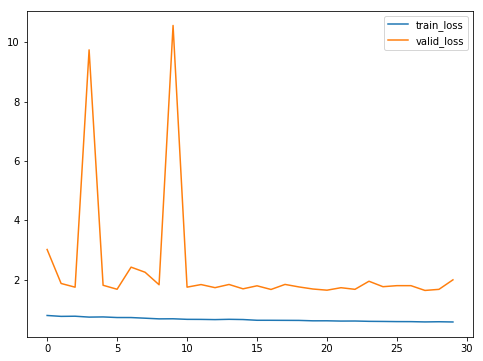

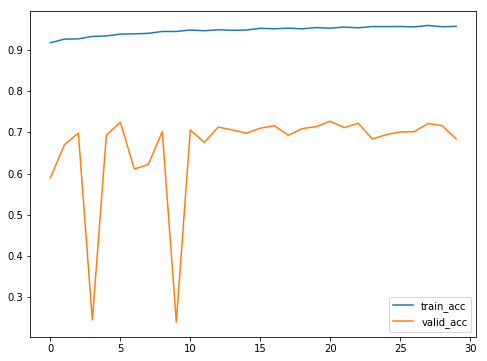

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,6))
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'valid_loss')
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
plt.plot(history.history['acc'], label = 'train_acc')
plt.plot(history.history['val_acc'], label = 'valid_acc')
plt.legend()
plt.show()